## **Recurrent Autoencoder for Anomaly Detection**

In [1]:
# package 불러오기

import io
import os
import time
import copy
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
!git clone https://github.com/yun-seon/DX-Training-LGES-0628.git

Cloning into 'DX-Training-LGES-0628'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 29 (delta 8), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (29/29), 7.48 MiB | 3.08 MiB/s, done.


In [3]:
# load the dataset
data = pd.read_csv("/content/DX-Training-LGES-0628/Data_sensor-filtered.csv")
data = data.iloc[:150000, ]

data.head()

,timestamp,sensor_04,sensor_06,sensor_07,sensor_08,sensor_09,machine_status
0,2018-04-01 00:00:00,634.3750,13.41146,16.13136,15.56713,15.05353,0
1,2018-04-01 00:01:00,634.3750,13.41146,16.13136,15.56713,15.05353,0
2,2018-04-01 00:02:00,638.8889,13.32465,16.03733,15.61777,15.01013,0
3,2018-04-01 00:03:00,628.1250,13.31742,16.24711,15.69734,15.08247,0
4,2018-04-01 00:04:00,636.4583,13.35359,16.21094,15.69734,15.08247,0


In [4]:
print("Anomaly ratio: ", data[data['machine_status']==1].shape[0]/data.shape[0], "\n")

data['machine_status'].value_counts()

Anomaly ratio:  0.09605333333333334 



0    135592
1     14408
Name: machine_status, dtype: int64

### *Hyperparameter Setting*

  * batch_size: 학습 및 검증에 사용할 배치의 크기
  * num_epochs: 학습할 epoch 횟수
  * window_size: input의 시간 길이 (time series data에서 도출한 subsequence의 길이)
  * input_size: 변수 개수
  * hidden_size: 모델의 hidden dimension
  * num_layers: 모델의 layer 개수
  * random_seed: reproduction을 위해 고정할 seed의 값

In [5]:
# Hyperparameter setting (변경 가능)

batch_size = 32
num_epochs = 20
window_size = 5
input_size = 5
hidden_size = 2
num_layers = 1

random_seed = 42
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Detect if we have a GPU available

In [6]:
# seed 고정
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [7]:
# train/validation/test data split
# data shape: (220320, 6)

X_train = data.iloc[:80000, 1:-1] # timestamp 제거
y_train = data.iloc[:80000, -1].values

X_valid = data.iloc[80000:110000, 1:-1] # timestamp 제거
y_valid = data.iloc[80000:110000, -1].values

X_test = data.iloc[110000:, 1:-1] # timestamp 제거
y_test = data.iloc[110000:, -1].values

print("Train data shape:", X_train.shape)
print("Validation data shape:", X_valid.shape)
print("Test data shape:", X_test.shape)

Train data shape: (80000, 5)
Validation data shape: (30000, 5)
Test data shape: (40000, 5)


In [8]:
# train 데이터를 기반으로 train/test 데이터에 대하여 min-max scaling 적용 (normalization)

scaler = MinMaxScaler()
scaler = scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [9]:
# normal data filtering

X_train_nm = X_train[np.where(y_train==0)]
y_train_nm = y_train[np.where(y_train==0)]

X_valid_nm = X_valid[np.where(y_valid==0)]
y_valid_nm = y_valid[np.where(y_valid==0)]

print("Train data shape:", X_train_nm.shape)
print("Validation data shape:", X_valid_nm.shape)
print("Test data shape:", X_test.shape)

Train data shape: (74025, 5)
Validation data shape: (30000, 5)
Test data shape: (40000, 5)


In [10]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len
        self.start_point = range(0, len(data) - seq_len)

    # 총 데이터의 개수를 리턴
    def __len__(self):
        return len(self.start_point)

    # 인덱스를 입력받아 그에 맵핑되는 입출력 데이터를 파이토치의 Tensor 형태로 리턴
    def __getitem__(self, idx):
        x = torch.FloatTensor(self.data[self.start_point[idx]:self.start_point[idx] + self.seq_len]) # shape: (seq_len, n_features)
        x = torch.transpose(x, 1, 0) # shape: (n_features, seq_len)
        return x

In [11]:
# Data load
train_dataset = CustomDataset(X_train_nm, window_size)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = CustomDataset(X_valid_nm, window_size)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

test_dataset = CustomDataset(X_test, window_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

> ## Recurrent Autoencoder (RAE) Modeling

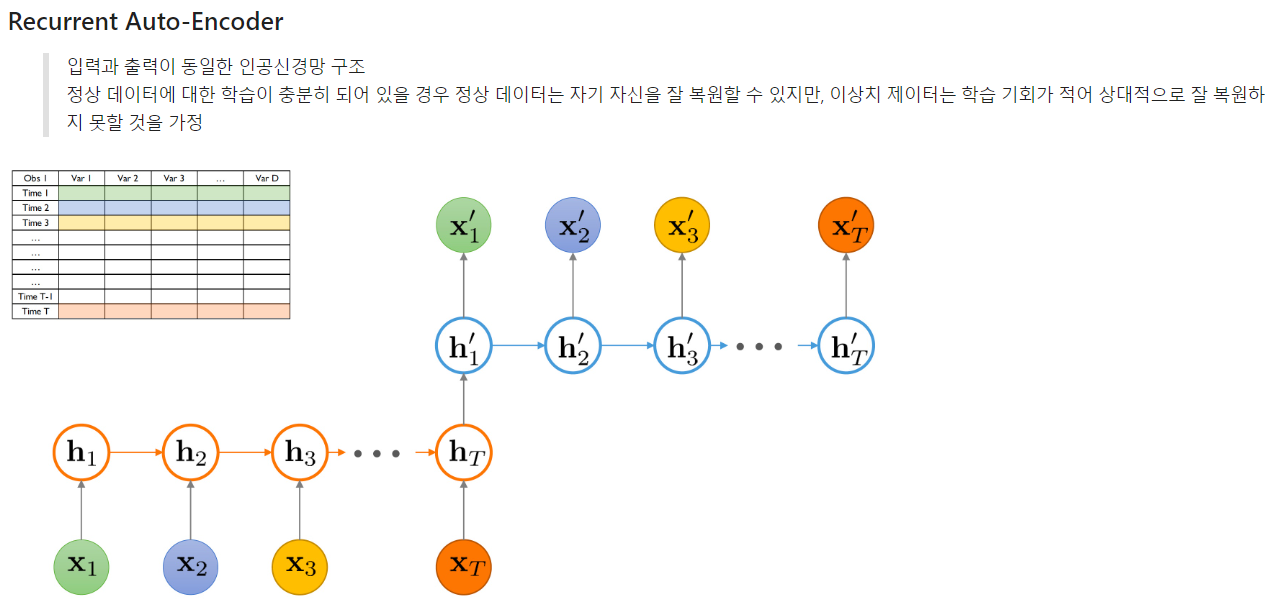

In [12]:
# Architecture of Recurrent Autoencoder model
class RAE(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, seq_len):
        super(RAE, self).__init__()
        self.seq_len = seq_len

        self.encoder = nn.LSTM(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            batch_first=True
        )
        self.decoder = nn.LSTM(
            input_size = hidden_size,
            hidden_size = 2 * hidden_size,
            num_layers = num_layers,
            batch_first = True
        )
        self.fc = nn.Linear(2 * hidden_size, input_size)

    def forward(self, x):
        # data dimension: (batch_size x input_size x seq_len) -> (batch_size x seq_len x input_size)로 변환
        x = torch.transpose(x, 1, 2)

        enc_x, (enc_hidden_state, enc_cell_state) = self.encoder(x)
        enc_last_hidden = enc_hidden_state[-1, :, :]

        enc_last_hidden = enc_last_hidden.unsqueeze(1).repeat(1, self.seq_len, 1)
        dec_x, (dec_hidden_state, dec_cell_state) = self.decoder(enc_last_hidden)
        dec_x = dec_x.reshape((x.size(0), self.seq_len, -1))

        out = self.fc(dec_x)
        out = torch.sigmoid(out)
        out = torch.transpose(out, 1, 2)
        return out

In [13]:
# RAE 모델 구축
model = RAE(input_size, hidden_size, num_layers, seq_len=window_size)
model = model.to(device)
print(model)

RAE(
  (encoder): LSTM(5, 2, batch_first=True)
  (decoder): LSTM(2, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=5, bias=True)
)


In [14]:
# RAE train function
def train_model(model, dataloaders, criterion, num_epochs, optimizer):
    since = time.time()

    val_mse_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_mse = 10000000

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # 각 epoch마다 순서대로 training과 validation을 진행
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 training mode로 설정
            else:
                model.eval()   # 모델을 validation mode로 설정

            running_loss = 0.0
            running_total = 0

            # training과 validation 단계에 맞는 dataloader에 대하여 학습/검증 진행
            for inputs in dataloaders[phase]:
                inputs = inputs.to(device)

                # parameter gradients를 0으로 설정
                optimizer.zero_grad()

                # forward
                # training 단계에서만 gradient 업데이트 수행
                with torch.set_grad_enabled(phase == 'train'):
                    # input을 model에 넣어 output을 도출한 후, loss를 계산함
                    outputs = model(inputs)
                    loss = criterion(outputs, inputs)

                    # backward (optimize): training 단계에서만 수행
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # batch별 loss를 축적함
                running_loss += loss.item() * inputs.size(0)
                running_total += inputs.size(0)

            # epoch의 loss 및 RMSE 도출
            epoch_loss = running_loss / running_total

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))

            # validation 단계에서 validation loss가 감소할 때마다 best model 가중치를 업데이트함
            if phase == 'val' and epoch_loss < best_mse:
                best_mse = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_mse_history.append(epoch_loss)

        print()

    # 전체 학습 시간 계산
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val MSE: {:4f}'.format(best_mse))

    # validation loss가 가장 낮았을 때의 best model 가중치를 불러와 best model을 구축함
    model.load_state_dict(best_model_wts)

    # best model 가중치 저장
    # torch.save(best_model_wts, '../output/best_model.pt')
    return model, val_mse_history

In [15]:
# trining 단계에서 사용할 Dataloader dictionary 생성
dataloaders_dict = {
    'train': train_loader,
    'val': valid_loader
}

In [16]:
# loss function 설정
criterion = nn.MSELoss()

In [17]:
# RAE 모델 학습
model, val_mse_history = train_model(model, dataloaders_dict, criterion, num_epochs,
                                     optimizer=optim.Adam(model.parameters(), lr=0.0001))

Epoch 1/20
----------
train Loss: 0.0530
val Loss: 0.0150

Epoch 2/20
----------
train Loss: 0.0086
val Loss: 0.0038

Epoch 3/20
----------
train Loss: 0.0040
val Loss: 0.0015

Epoch 4/20
----------
train Loss: 0.0029
val Loss: 0.0007

Epoch 5/20
----------
train Loss: 0.0024
val Loss: 0.0004

Epoch 6/20
----------
train Loss: 0.0022
val Loss: 0.0004

Epoch 7/20
----------
train Loss: 0.0011
val Loss: 0.0003

Epoch 8/20
----------
train Loss: 0.0007
val Loss: 0.0002

Epoch 9/20
----------
train Loss: 0.0006
val Loss: 0.0002

Epoch 10/20
----------
train Loss: 0.0005
val Loss: 0.0002

Epoch 11/20
----------
train Loss: 0.0005
val Loss: 0.0002

Epoch 12/20
----------
train Loss: 0.0005
val Loss: 0.0002

Epoch 13/20
----------
train Loss: 0.0005
val Loss: 0.0002

Epoch 14/20
----------
train Loss: 0.0005
val Loss: 0.0002

Epoch 15/20
----------
train Loss: 0.0005
val Loss: 0.0002

Epoch 16/20
----------
train Loss: 0.0005
val Loss: 0.0002

Epoch 17/20
----------
train Loss: 0.0004
val Los

In [18]:
'''
적합된 모델을 기반으로 train/valid/test 데이터의 anomaly score 도출
'''
def test_model(model, test_loader, criterion):
    model.eval()   # 모델을 validation mode로 설정

    # test_loader에 대하여 anomaly score 도출 (gradient update 방지)
    with torch.no_grad():
        test_loss = []
        for inputs in test_loader:
            inputs = inputs.to(device)

            # forward
            # input을 model에 넣어 output을 도출한 후, loss를 계산함
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss = loss.mean(axis=-1).mean(axis=-1)

            # sample별 loss를 축적함
            test_loss += loss.cpu().data.numpy().tolist()

    return test_loss

In [19]:
# loss function 설정하기

ad_criterion = nn.L1Loss(reduction='none')

In [20]:
# train/valid/test 데이터에 대한 최종 결과 도출

train_loss = test_model(model, train_loader, ad_criterion)
valid_loss = test_model(model, valid_loader, ad_criterion)
test_loss = test_model(model, test_loader, ad_criterion)

<ipython-input-21-229119816b6a>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_loss, bins=100, kde=True, color='blue', ax=ax1)
<ipython-input-21-229119816b6a>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(valid_loss, bins=100, kde=True, color='blue', ax=ax2)
<ipython-input-21-22911981

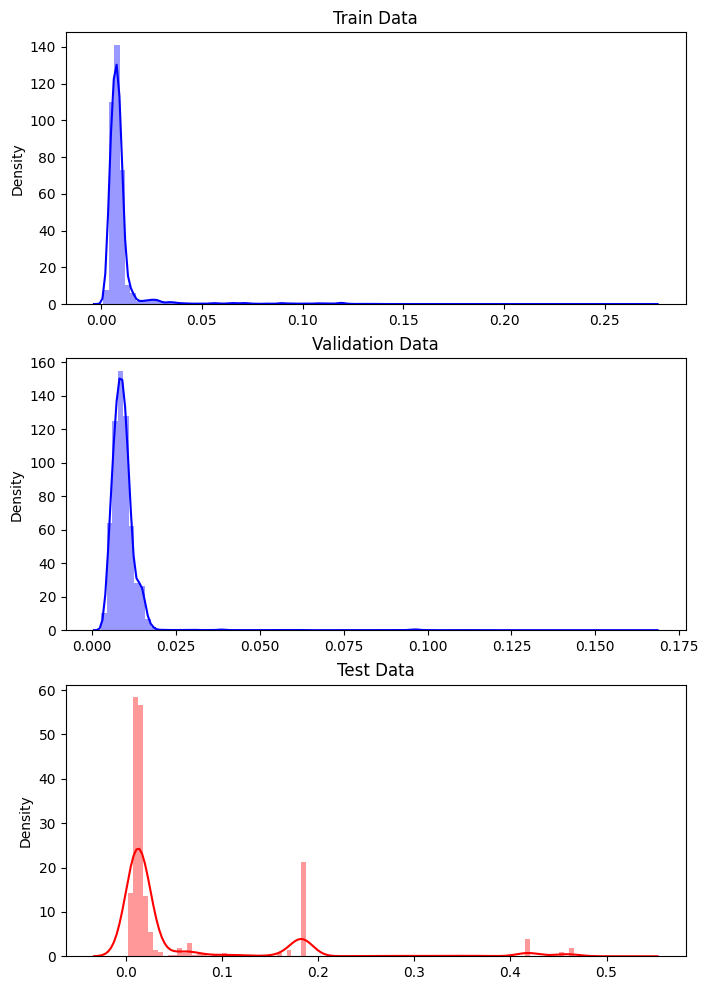

In [21]:
# valid/test 데이터의 anomaly score 분포 시각화
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize = (8, 12))

sns.distplot(train_loss, bins=100, kde=True, color='blue', ax=ax1)
sns.distplot(valid_loss, bins=100, kde=True, color='blue', ax=ax2)
sns.distplot(test_loss, bins=100, kde=True, color='red', ax=ax3)

ax1.set_title("Train Data")
ax2.set_title("Validation Data")
ax3.set_title("Test Data")
plt.show()

### **(1) Thresholding based on F1 score**

In [22]:
'''
Thresholding #1. 임의의 값으로 threshold 변경 후, f1 score 값이 가장 높은 threshold를 최종 선정
'''

# score의 min ~ max 범위를 num_step개로 균등 분할한 threshold에 대하여 best threshold 탐색
def search_best_threshold(score, y_true, num_step):

    best_f1 = 0.5
    best_threshold = None
    for threshold in np.linspace(min(score), max(score), num_step):
        y_pred = threshold < score

        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    print('Best threshold: ', best_threshold, 4)
    print('Best F1 Score:', best_f1, 4)
    return best_threshold

In [23]:
# best threshold 탐색 (Best threshold:  0.0707)
best_threshold = search_best_threshold(test_loss, y_test[window_size:], num_step=1000)

Best threshold:  0.055246756271318385 4
Best F1 Score: 0.9216934306569343 4


In [24]:
'''
Best threshold를 기반으로 이상치 탐지 모델 재평가(train/valid/test)
'''
scores = pd.DataFrame()

scores['score'] = list(np.hstack([train_loss, valid_loss, test_loss]))
scores['anomaly'] = (best_threshold < scores['score'])*1  # True/False를 1/0으로 표현

scores['anomaly'].value_counts()

0    133463
1     10547
Name: anomaly, dtype: int64

In [25]:
scores['labels'] = np.hstack((y_train_nm[5:], y_valid_nm[5:], y_test[5:]))

scores

,score,anomaly,labels
0,0.010087,0,0
1,0.004432,0,0
2,0.005141,0,0
3,0.004179,0,0
4,0.010635,0,0
...,...,...,...
144005,0.009368,0,0
144006,0.010376,0,0
144007,0.010430,0,0
144008,0.010700,0,0


In [26]:
# 성능 평가표
print("Classification Report :")
print(classification_report(scores['labels'], scores['anomaly']))

Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    135577
           1       0.75      0.94      0.83      8433

    accuracy                           0.98    144010
   macro avg       0.87      0.96      0.91    144010
weighted avg       0.98      0.98      0.98    144010



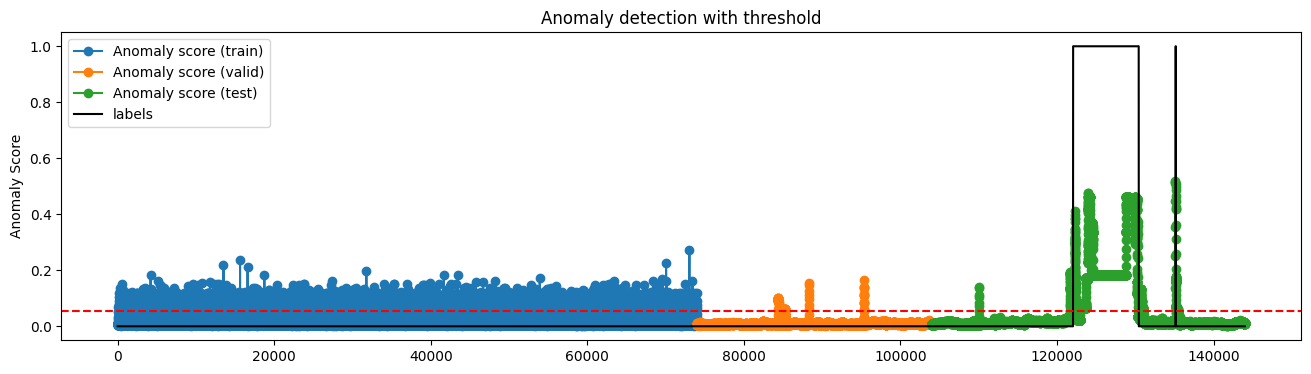

In [27]:
# Anomaly score와 실제 레이블 간의 정합성 확인 (시각화)
plt.figure(figsize = (16, 4))

plt.plot(scores.loc[:y_train_nm[5:].shape[0], 'score'], marker='o', label = 'Anomaly score (train)')
plt.plot(scores.loc[y_train_nm[5:].shape[0]:(y_train_nm[5:].shape[0])+(y_valid_nm[5:].shape[0]), 'score'], marker='o', label = 'Anomaly score (valid)')
plt.plot(scores.loc[(y_train_nm[5:].shape[0])+(y_valid_nm[5:].shape[0]):, 'score'], marker='o', label = 'Anomaly score (test)')
plt.plot(scores['labels'], color = 'k', label = 'labels')

plt.axhline(best_threshold, color = 'r', linestyle = '--')
plt.title("Anomaly detection with threshold")
plt.ylabel("Anomaly Score")
plt.legend()
plt.show()

* Smoothing 기법

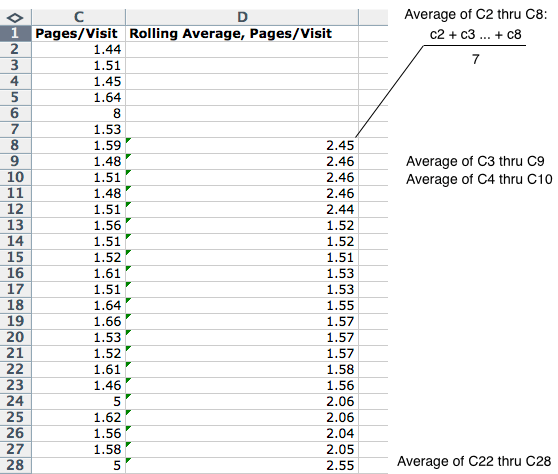

In [28]:
# Anomaly score의 변동성이 매우 클 경우, smoothing 작업 추가
scores_smoothing = scores.iloc[10:, :]

scores_smoothing['score'] = scores['score'].rolling(10).mean().dropna()
scores_smoothing

<ipython-input-28-2d058ee881ab>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores_smoothing['score'] = scores['score'].rolling(10).mean().dropna()


,score,anomaly,labels
10,0.007280,0,0
11,0.007360,0,0
12,0.007722,0,0
13,0.007968,0,0
14,0.007523,0,0
...,...,...,...
144005,0.010340,0,0
144006,0.010398,0,0
144007,0.010444,0,0
144008,0.010442,0,0


In [29]:
# 성능 평가표
print("Classification Report :")
print(classification_report(scores_smoothing['labels'], scores_smoothing['anomaly']))

Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    135567
           1       0.75      0.94      0.83      8433

    accuracy                           0.98    144000
   macro avg       0.87      0.96      0.91    144000
weighted avg       0.98      0.98      0.98    144000



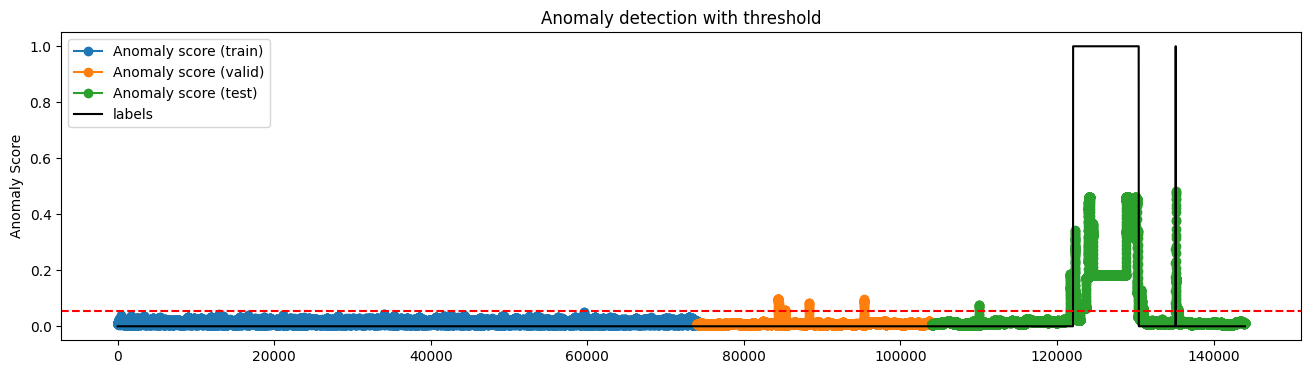

In [30]:
# Anomaly score와 실제 레이블 간의 정합성 확인 (Smoothing for Anomaly Score)
plt.figure(figsize = (16, 4))

plt.plot(scores_smoothing.loc[:y_train_nm[5:].shape[0], 'score'], marker='o', label = 'Anomaly score (train)')
plt.plot(scores_smoothing.loc[y_train_nm[5:].shape[0]:(y_train_nm[5:].shape[0])+(y_valid_nm[5:].shape[0]), 'score'], marker='o', label = 'Anomaly score (valid)')
plt.plot(scores_smoothing.loc[(y_train_nm[5:].shape[0])+(y_valid_nm[5:].shape[0]):, 'score'], marker='o', label = 'Anomaly score (test)')
plt.plot(scores_smoothing['labels'], color = 'k', label = 'labels')

plt.axhline(best_threshold, color = 'r', linestyle = '--')
plt.title("Anomaly detection with threshold")
plt.ylabel("Anomaly Score")
plt.legend()
plt.show()

### **(2) Thresholding based on Statistics**

In [31]:
'''
Thresholding #2. 정상 데이터에 대한 통계량을 threshold으로 설정
'''

# score의 min ~ max 범위를 num_step개로 균등 분할한 threshold에 대하여 best threshold 탐색
def search_threshold_statistics(thres_type, score):

    if thres_type == "bound_2sigm":
      stat_threshold = [np.mean(score)-2*np.std(score), np.mean(score)+2*np.std(score)]

    elif thres_type == "bound_3sigm":
      stat_threshold = [np.mean(score)-3*np.std(score), np.mean(score)+3*np.std(score)]

    elif thres_type == "perc_90":
      stat_threshold = np.percentile(np.abs(score), 90)

    elif thres_type == "perc_95":
      stat_threshold = np.percentile(np.abs(score), 95)

    elif thres_type == "perc_99":
      stat_threshold = np.percentile(np.abs(score), 90)

    elif "mean_" in thres_type:
      stat_threshold = np.mean(score)*int(thres_type[-1:])

    else:
      print("Please enter the type!")

    print(thres_type)
    return stat_threshold

*Threshold. Upper bound & Lower bound*

In [32]:
# 통계량 기반 threshold 탐색
threshold_type = "bound_3sigm"

stat_threshold = search_threshold_statistics(threshold_type, train_loss)
stat_threshold

bound_3sigm


[-0.032610079990453136, 0.05350772162207222]

In [33]:
'''
Best threshold를 기반으로 이상치 탐지 모델 재평가(train/valid/test)
'''
scores = pd.DataFrame()

if (threshold_type == "bound_2sigm")|(threshold_type == "bound_3sigm"):
    scores['score'] = list(np.hstack([train_loss, valid_loss, test_loss]))
    scores['anomaly'] = ((scores['score'] < stat_threshold[0])|(stat_threshold[1] < scores['score']))*1  # True/False를 1/0으로 표현
    scores['labels'] = np.hstack((y_train_nm[5:], y_valid_nm[5:], y_test[5:]))

else:
    scores['score'] = list(np.hstack([train_loss, valid_loss, test_loss]))
    scores['anomaly'] = (stat_threshold < scores['score'])*1  # True/False를 1/0으로 표현
    scores['labels'] = np.hstack((y_train_nm[5:], y_valid_nm[5:], y_test[5:]))

scores['anomaly'].value_counts()

0    133343
1     10667
Name: anomaly, dtype: int64

In [34]:
# 성능 평가표
print("Classification Report :")
print(classification_report(scores['labels'], scores['anomaly']))

Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    135577
           1       0.74      0.94      0.83      8433

    accuracy                           0.98    144010
   macro avg       0.87      0.96      0.91    144010
weighted avg       0.98      0.98      0.98    144010



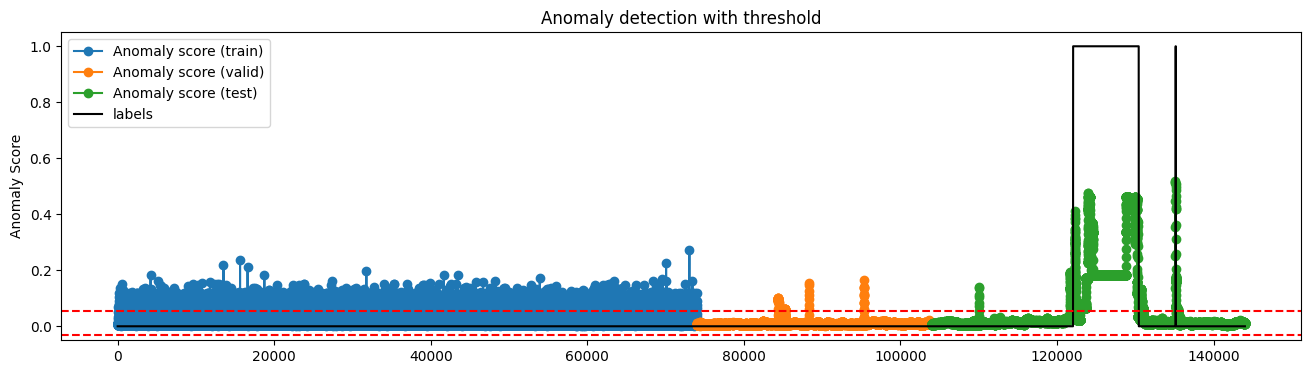

In [35]:
# Anomaly score와 실제 레이블 간의 정합성 확인 (시각화)
plt.figure(figsize = (16, 4))

plt.plot(scores.loc[:y_train_nm[5:].shape[0], 'score'], marker='o', label = 'Anomaly score (train)')
plt.plot(scores.loc[y_train_nm[5:].shape[0]:(y_train_nm[5:].shape[0])+(y_valid_nm[5:].shape[0]), 'score'], marker='o', label = 'Anomaly score (valid)')
plt.plot(scores.loc[(y_train_nm[5:].shape[0])+(y_valid_nm[5:].shape[0]):, 'score'], marker='o', label = 'Anomaly score (test)')
plt.plot(scores['labels'], color = 'k', label = 'labels')

if (threshold_type == "bound_2sigm")|(threshold_type == "bound_3sigm"):
    plt.axhline(stat_threshold[0], color = 'r', linestyle = '--')
    plt.axhline(stat_threshold[1], color = 'r', linestyle = '--')
else:
    plt.axhline(stat_threshold, color = 'r', linestyle = '--')

plt.title("Anomaly detection with threshold")
plt.ylabel("Anomaly Score")
plt.legend()
plt.show()

In [36]:
# Anomaly score의 변동성이 매우 클 경우, smoothing 작업 추가
scores_smoothing = scores.iloc[10:, :]

scores_smoothing['score'] = scores['score'].rolling(10).mean().dropna()
scores_smoothing

<ipython-input-36-2d058ee881ab>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores_smoothing['score'] = scores['score'].rolling(10).mean().dropna()


,score,anomaly,labels
10,0.007280,0,0
11,0.007360,0,0
12,0.007722,0,0
13,0.007968,0,0
14,0.007523,0,0
...,...,...,...
144005,0.010340,0,0
144006,0.010398,0,0
144007,0.010444,0,0
144008,0.010442,0,0


In [37]:
# 성능 평가표
print("Classification Report :")
print(classification_report(scores_smoothing['labels'], scores_smoothing['anomaly']))

Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    135567
           1       0.74      0.94      0.83      8433

    accuracy                           0.98    144000
   macro avg       0.87      0.96      0.91    144000
weighted avg       0.98      0.98      0.98    144000



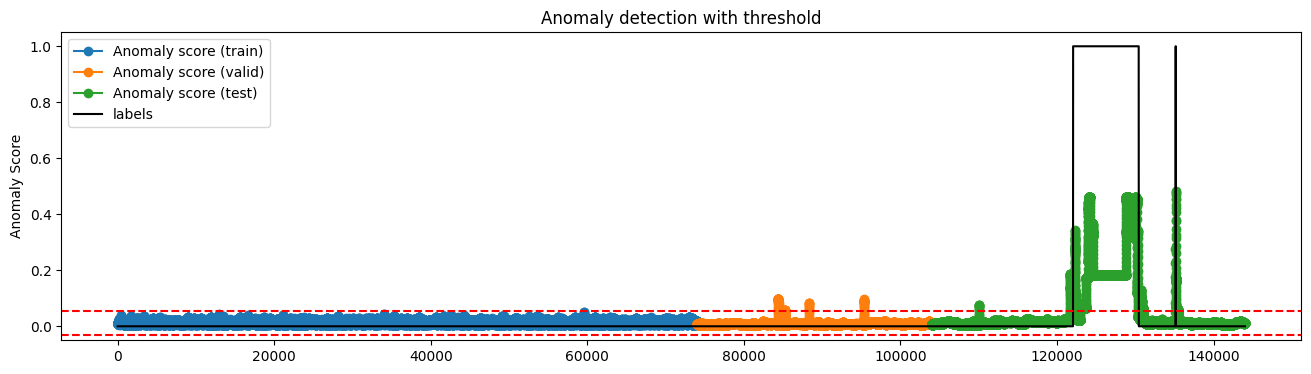

In [39]:
# Anomaly score와 실제 레이블 간의 정합성 확인 (Smoothing for Anomaly Score)
plt.figure(figsize = (16, 4))

plt.plot(scores_smoothing.loc[:y_train_nm[5:].shape[0], 'score'], marker='o', label = 'Anomaly score (train)')
plt.plot(scores_smoothing.loc[y_train_nm[5:].shape[0]:(y_train_nm[5:].shape[0])+(y_valid_nm[5:].shape[0]), 'score'], marker='o', label = 'Anomaly score (valid)')
plt.plot(scores_smoothing.loc[(y_train_nm[5:].shape[0])+(y_valid_nm[5:].shape[0]):, 'score'], marker='o', label = 'Anomaly score (test)')
plt.plot(scores_smoothing['labels'], color = 'k', label = 'labels')

if (threshold_type == "bound_2sigm")|(threshold_type == "bound_3sigm"):
    plt.axhline(stat_threshold[0], color = 'r', linestyle = '--')
    plt.axhline(stat_threshold[1], color = 'r', linestyle = '--')
else:
    plt.axhline(stat_threshold, color = 'r', linestyle = '--')

plt.title("Anomaly detection with threshold")
plt.ylabel("Anomaly Score")
plt.legend()
plt.show()

*Threshold. Percentile*

In [40]:
# 통계량 기반 threshold 탐색
threshold_type = "perc_99"

stat_threshold = search_threshold_statistics(threshold_type, train_loss)
stat_threshold

perc_99


0.012082686275243762

In [41]:
'''
Best threshold를 기반으로 이상치 탐지 모델 재평가(train/valid/test)
'''
scores = pd.DataFrame()

if (threshold_type == "bound_2sigm")|(threshold_type == "bound_3sigm"):
    scores['score'] = list(np.hstack([train_loss, valid_loss, test_loss]))
    scores['anomaly'] = ((scores['score'] < stat_threshold[0])|(stat_threshold[1] < scores['score']))*1  # True/False를 1/0으로 표현
    scores['labels'] = np.hstack((y_train_nm[5:], y_valid_nm[5:], y_test[5:]))

else:
    scores['score'] = list(np.hstack([train_loss, valid_loss, test_loss]))
    scores['anomaly'] = (stat_threshold < scores['score'])*1  # True/False를 1/0으로 표현
    scores['labels'] = np.hstack((y_train_nm[5:], y_valid_nm[5:], y_test[5:]))

scores['anomaly'].value_counts()

0    107290
1     36720
Name: anomaly, dtype: int64

In [42]:
# 성능 평가표
print("Classification Report :")
print(classification_report(scores['labels'], scores['anomaly']))

Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.79      0.88    135577
           1       0.23      1.00      0.37      8433

    accuracy                           0.80    144010
   macro avg       0.61      0.90      0.63    144010
weighted avg       0.95      0.80      0.85    144010



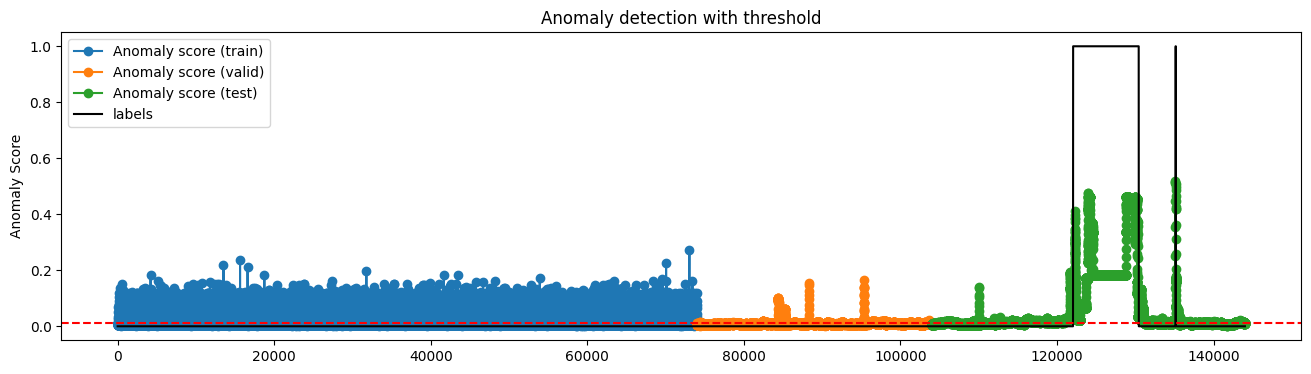

In [43]:
# Anomaly score와 실제 레이블 간의 정합성 확인 (시각화)
plt.figure(figsize = (16, 4))

plt.plot(scores.loc[:y_train_nm[5:].shape[0], 'score'], marker='o', label = 'Anomaly score (train)')
plt.plot(scores.loc[y_train_nm[5:].shape[0]:(y_train_nm[5:].shape[0])+(y_valid_nm[5:].shape[0]), 'score'], marker='o', label = 'Anomaly score (valid)')
plt.plot(scores.loc[(y_train_nm[5:].shape[0])+(y_valid_nm[5:].shape[0]):, 'score'], marker='o', label = 'Anomaly score (test)')
plt.plot(scores['labels'], color = 'k', label = 'labels')

if (threshold_type == "bound_2sigm")|(threshold_type == "bound_3sigm"):
    plt.axhline(stat_threshold[0], color = 'r', linestyle = '--')
    plt.axhline(stat_threshold[1], color = 'r', linestyle = '--')
else:
    plt.axhline(stat_threshold, color = 'r', linestyle = '--')

plt.title("Anomaly detection with threshold")
plt.ylabel("Anomaly Score")
plt.legend()
plt.show()

In [44]:
# Anomaly score의 변동성이 매우 클 경우, smoothing 작업 추가
scores_smoothing = scores.iloc[10:, :]

scores_smoothing['score'] = scores['score'].rolling(10).mean().dropna()
scores_smoothing

<ipython-input-44-2d058ee881ab>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores_smoothing['score'] = scores['score'].rolling(10).mean().dropna()


,score,anomaly,labels
10,0.007280,0,0
11,0.007360,0,0
12,0.007722,0,0
13,0.007968,0,0
14,0.007523,0,0
...,...,...,...
144005,0.010340,0,0
144006,0.010398,0,0
144007,0.010444,0,0
144008,0.010442,0,0


In [45]:
# 성능 평가표
print("Classification Report :")
print(classification_report(scores_smoothing['labels'], scores_smoothing['anomaly']))

Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.79      0.88    135567
           1       0.23      1.00      0.37      8433

    accuracy                           0.80    144000
   macro avg       0.61      0.90      0.63    144000
weighted avg       0.95      0.80      0.85    144000



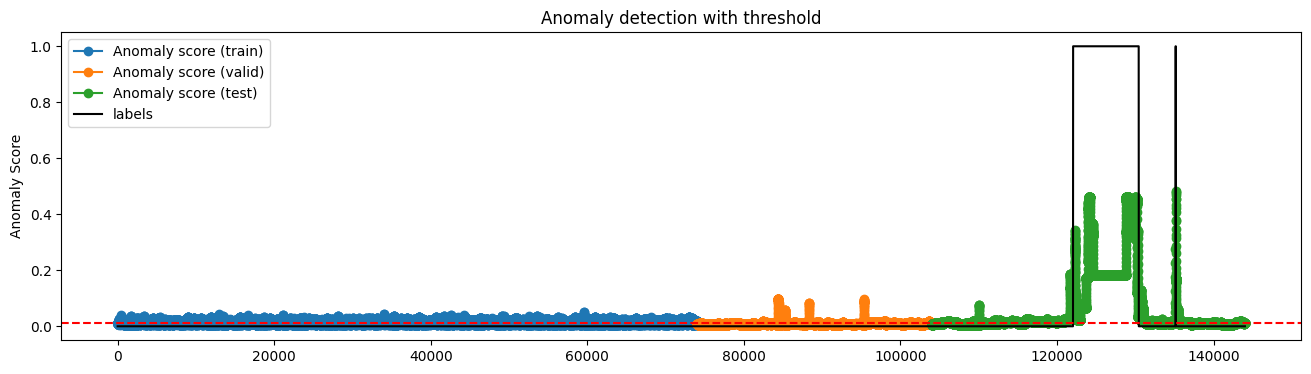

In [46]:
# Anomaly score와 실제 레이블 간의 정합성 확인 (Smoothing for Anomaly Score)
plt.figure(figsize = (16, 4))

plt.plot(scores_smoothing.loc[:y_train_nm[5:].shape[0], 'score'], marker='o', label = 'Anomaly score (train)')
plt.plot(scores_smoothing.loc[y_train_nm[5:].shape[0]:(y_train_nm[5:].shape[0])+(y_valid_nm[5:].shape[0]), 'score'], marker='o', label = 'Anomaly score (valid)')
plt.plot(scores_smoothing.loc[(y_train_nm[5:].shape[0])+(y_valid_nm[5:].shape[0]):, 'score'], marker='o', label = 'Anomaly score (test)')
plt.plot(scores_smoothing['labels'], color = 'k', label = 'labels')

plt.axhline(stat_threshold, color = 'r', linestyle = '--')
plt.title("Anomaly detection with threshold")
plt.ylabel("Anomaly Score")
plt.legend()
plt.show()

*Threshold. n times from mean*

In [47]:
# 통계량 기반 threshold 탐색
threshold_type = "mean_3"

stat_threshold = search_threshold_statistics(threshold_type, train_loss)
stat_threshold

mean_3


0.03134646244742864

In [48]:
'''
Best threshold를 기반으로 이상치 탐지 모델 재평가(train/valid/test)
'''
scores = pd.DataFrame()

if (threshold_type == "bound_2sigm")|(threshold_type == "bound_3sigm"):
    scores['score'] = list(np.hstack([train_loss, valid_loss, test_loss]))
    scores['anomaly'] = ((scores['score'] < stat_threshold[0])|(stat_threshold[1] < scores['score']))*1  # True/False를 1/0으로 표현
    scores['labels'] = np.hstack((y_train_nm[5:], y_valid_nm[5:], y_test[5:]))

else:
    scores['score'] = list(np.hstack([train_loss, valid_loss, test_loss]))
    scores['anomaly'] = (stat_threshold < scores['score'])*1  # True/False를 1/0으로 표현
    scores['labels'] = np.hstack((y_train_nm[5:], y_valid_nm[5:], y_test[5:]))

scores['anomaly'].value_counts()

0    132004
1     12006
Name: anomaly, dtype: int64

In [49]:
# 성능 평가표
print("Classification Report :")
print(classification_report(scores['labels'], scores['anomaly']))

Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.97      0.98    135577
           1       0.67      0.95      0.78      8433

    accuracy                           0.97    144010
   macro avg       0.83      0.96      0.88    144010
weighted avg       0.98      0.97      0.97    144010



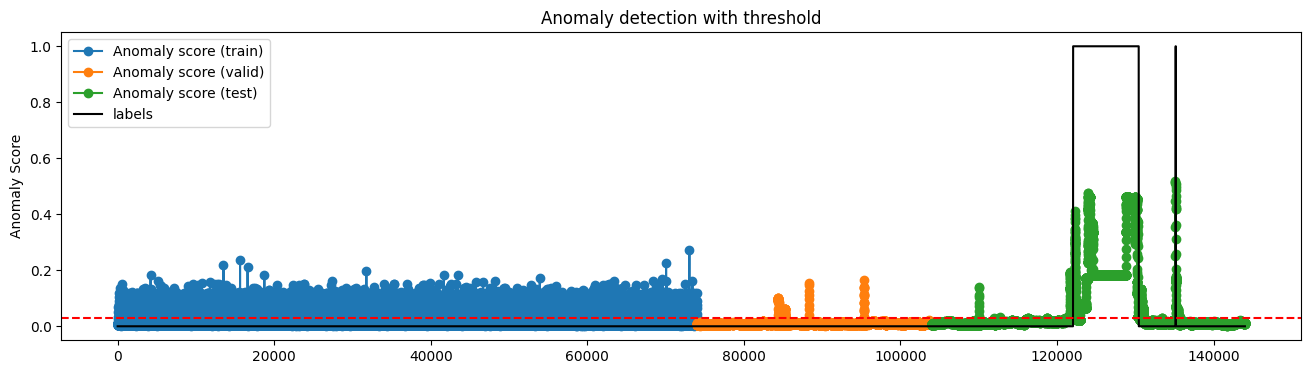

In [50]:
# Anomaly score와 실제 레이블 간의 정합성 확인 (시각화)
plt.figure(figsize = (16, 4))

plt.plot(scores.loc[:y_train_nm[5:].shape[0], 'score'], marker='o', label = 'Anomaly score (train)')
plt.plot(scores.loc[y_train_nm[5:].shape[0]:(y_train_nm[5:].shape[0])+(y_valid_nm[5:].shape[0]), 'score'], marker='o', label = 'Anomaly score (valid)')
plt.plot(scores.loc[(y_train_nm[5:].shape[0])+(y_valid_nm[5:].shape[0]):, 'score'], marker='o', label = 'Anomaly score (test)')
plt.plot(scores['labels'], color = 'k', label = 'labels')

if (threshold_type == "bound_2sigm")|(threshold_type == "bound_3sigm"):
    plt.axhline(stat_threshold[0], color = 'r', linestyle = '--')
    plt.axhline(stat_threshold[1], color = 'r', linestyle = '--')
else:
    plt.axhline(stat_threshold, color = 'r', linestyle = '--')

plt.title("Anomaly detection with threshold")
plt.ylabel("Anomaly Score")
plt.legend()
plt.show()

In [51]:
# Anomaly score의 변동성이 매우 클 경우, smoothing 작업 추가
scores_smoothing = scores.iloc[10:, :]

scores_smoothing['score'] = scores['score'].rolling(10).mean().dropna()
scores_smoothing

<ipython-input-51-2d058ee881ab>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores_smoothing['score'] = scores['score'].rolling(10).mean().dropna()


,score,anomaly,labels
10,0.007280,0,0
11,0.007360,0,0
12,0.007722,0,0
13,0.007968,0,0
14,0.007523,0,0
...,...,...,...
144005,0.010340,0,0
144006,0.010398,0,0
144007,0.010444,0,0
144008,0.010442,0,0


In [52]:
# 성능 평가표
print("Classification Report :")
print(classification_report(scores_smoothing['labels'], scores_smoothing['anomaly']))

Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.97      0.98    135567
           1       0.67      0.95      0.78      8433

    accuracy                           0.97    144000
   macro avg       0.83      0.96      0.88    144000
weighted avg       0.98      0.97      0.97    144000



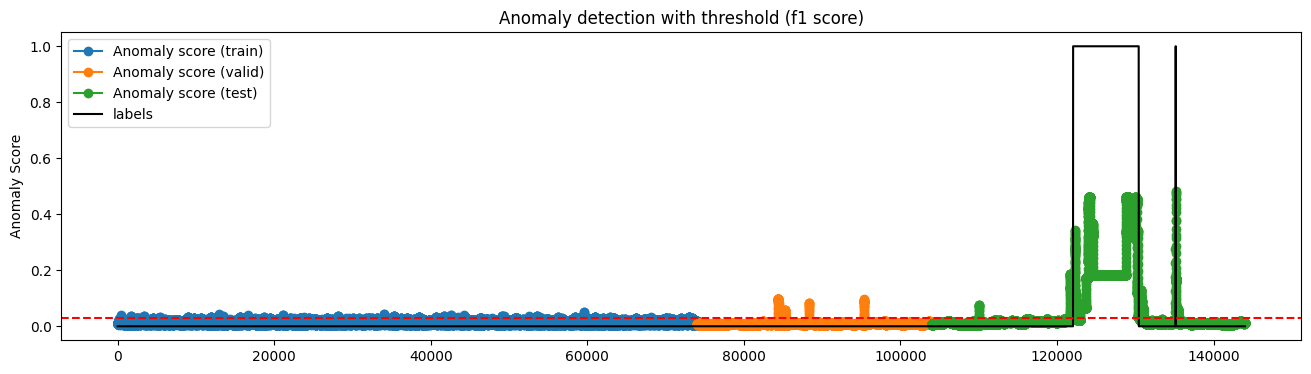

In [53]:
# Anomaly score와 실제 레이블 간의 정합성 확인 (Smoothing for Anomaly Score)
plt.figure(figsize = (16, 4))

plt.plot(scores_smoothing.loc[:y_train_nm[5:].shape[0], 'score'], marker='o', label = 'Anomaly score (train)')
plt.plot(scores_smoothing.loc[y_train_nm[5:].shape[0]:(y_train_nm[5:].shape[0])+(y_valid_nm[5:].shape[0]), 'score'], marker='o', label = 'Anomaly score (valid)')
plt.plot(scores_smoothing.loc[(y_train_nm[5:].shape[0])+(y_valid_nm[5:].shape[0]):, 'score'], marker='o', label = 'Anomaly score (test)')
plt.plot(scores_smoothing['labels'], color = 'k', label = 'labels')

plt.axhline(stat_threshold, color = 'r', linestyle = '--')
plt.title("Anomaly detection with threshold (f1 score)")
plt.ylabel("Anomaly Score")
plt.legend()
plt.show()

### **(3) Thresholding (per window)**

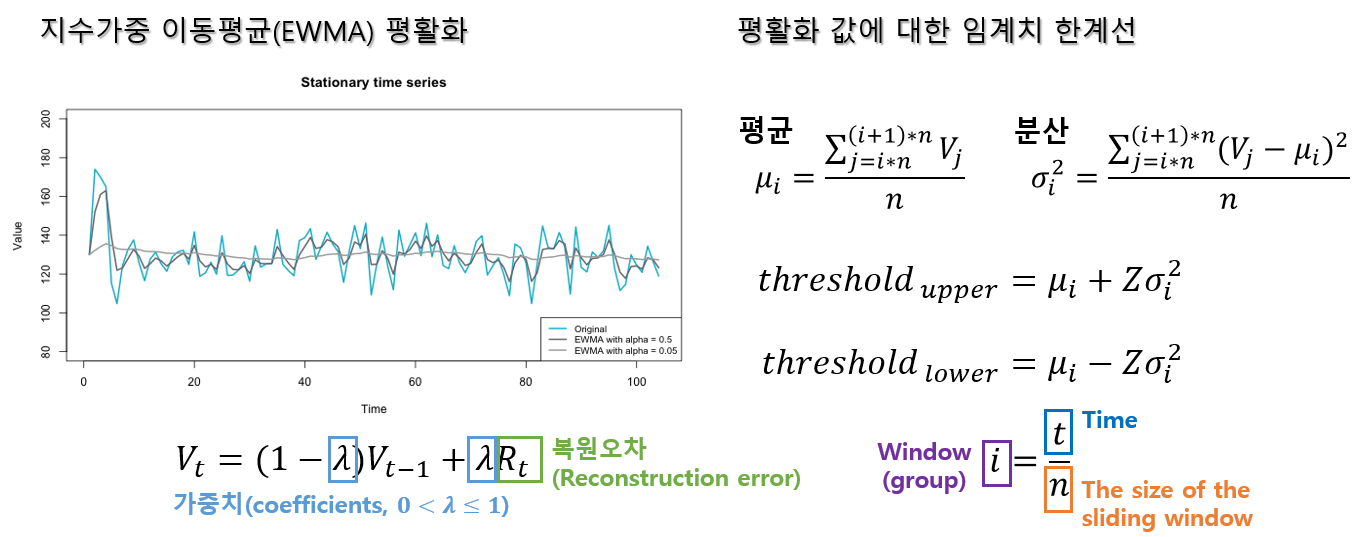

In [54]:
'''
Thresholding #2. 정상 데이터에 대한 통계량을 threshold으로 설정
'''

# score의 min ~ max 범위를 num_step개로 균등 분할한 threshold에 대하여 best threshold 탐색
def search_threshold_EWMA(z, loss, window):

  # loss에 대한 ewma 수행 시,
  # loss = pd.DataFrame(loss)[0].ewm(span=12).mean().asarray()

  tot_tmp = pd.DataFrame()
  for i in range(0, len(loss)//window):

      tmp = loss[i*window:(i+1)*window]
      ewma_threshold = [np.mean(tmp) - z*np.std(tmp), np.mean(tmp) + z*np.std(tmp)]

      tmp2 = pd.DataFrame(columns = ['score', 'thres1', 'thres2'])
      tmp2['score'] = tmp
      tmp2['thres1'] = ewma_threshold[0]
      tmp2['thres2'] = ewma_threshold[1]

      if i == 0:
        tot_tmp = tmp2

      else:
        tot_tmp = pd.concat([tot_tmp, tmp2], axis=0)

  return ewma_threshold, tot_tmp

In [55]:
# 통계량 기반 threshold 탐색
print("Hyperparameter (window size): ", window_size)
Z_score = 2

ewma_threshold, scores = search_threshold_EWMA(Z_score, test_loss, window_size)
print("threshold: ", ewma_threshold, "\n")

Hyperparameter (window size):  5
threshold:  [0.009310632780262139, 0.011121996655992363] 



In [56]:
scores

,score,thres1,thres2
0,0.007702,0.006867,0.008769
1,0.008341,0.006867,0.008769
2,0.007222,0.006867,0.008769
3,0.008399,0.006867,0.008769
4,0.007429,0.006867,0.008769
...,...,...,...
0,0.009368,0.009311,0.011122
1,0.010376,0.009311,0.011122
2,0.010430,0.009311,0.011122
3,0.010700,0.009311,0.011122


In [57]:
'''
Best threshold를 기반으로 이상치 탐지 모델 재평가(train/valid/test)
'''
scores['anomaly'] = ((scores['score'] < ewma_threshold[0])|(ewma_threshold[1] < scores['score']))*1  # True/False를 1/0으로 표현
scores['labels'] = np.hstack((y_test[5:]))

scores['anomaly'].value_counts()

1    35003
0     4992
Name: anomaly, dtype: int64

In [58]:
scores = scores.reset_index()
del scores['index']

scores

,score,thres1,thres2,anomaly,labels
0,0.007702,0.006867,0.008769,1,0
1,0.008341,0.006867,0.008769,1,0
2,0.007222,0.006867,0.008769,1,0
3,0.008399,0.006867,0.008769,1,0
4,0.007429,0.006867,0.008769,1,0
...,...,...,...,...,...
39990,0.009368,0.009311,0.011122,0,0
39991,0.010376,0.009311,0.011122,0,0
39992,0.010430,0.009311,0.011122,0,0
39993,0.010700,0.009311,0.011122,0,0


In [59]:
# 성능 평가표
print("Classification Report :")
print(classification_report(scores['labels'], scores['anomaly']))

Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.16      0.27     31562
           1       0.24      1.00      0.39      8433

    accuracy                           0.34     39995
   macro avg       0.62      0.58      0.33     39995
weighted avg       0.84      0.34      0.30     39995



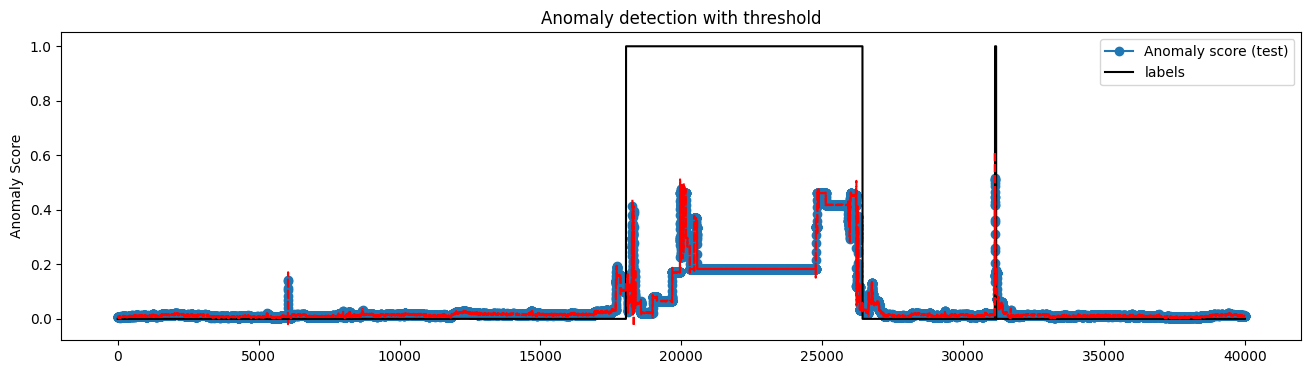

In [63]:
# Anomaly score와 실제 레이블 간의 정합성 확인 (시각화)
plt.figure(figsize = (16, 4))

plt.plot(scores['score'], marker='o', label = 'Anomaly score (test)')
plt.plot(scores['labels'], color = 'k', label = 'labels')

plt.plot(scores['thres1'], color = 'r', linestyle = '--')
plt.plot(scores['thres2'], color = 'r', linestyle = '--')

plt.title("Anomaly detection with threshold")
plt.ylabel("Anomaly Score")
plt.legend()
plt.show()